# Exploratory data analysis

In [2]:
import numpy as np
import pandas as pd
import os
import opendatasets as od
import cv2
import matplotlib.pyplot as plt

C:\Users\Nazar\AppData\Local\Temp\ipykernel_3624\3171157805.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Downloading data from kaggle

In [3]:
od.download("https://www.kaggle.com/c/airbus-ship-detection/data", data_dir='data')

Skipping, found downloaded files in "data\airbus-ship-detection" (use force=True to force download)


Saving labels as pandas dataframe

In [4]:
metadata = pd.read_csv(".//data//airbus-ship-detection//train_ship_segmentations_v2.csv")
metadata.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
metadata.shape

(231723, 2)

In [6]:
metadata['ImageId'].unique().shape

(192556,)

### Labels description
Labels are provides in the csv file. \
Each row contains image filename (ImageId) and a list of pixels in run-lenth encoding format (EncodedPixels). Pixels are the segment where a ship is. \
If EncodedPixels field is empty means there is no ship on the image \
Pixels of an image are indexed top-to-bottom and then left-to-right. \
The example 4x4 mask: 

$$\begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 1 & 1 & 0\\ 0 & 1 & 1 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}$$ 


The run-lenth encoding representation of the mask: 6, 2, 10,2

### Ships number destribution

Count the number of ships on each frame

In [7]:
ships_nums = pd.DataFrame(columns = ['ImageId'], data = metadata['ImageId'])

# 0 if encoded pixels field is empty, otherwise: the number of filename entries in
ships_nums['ShipsCount'] = metadata.apply(lambda row: 0 if pd.isna(row['EncodedPixels']) else 1, axis = 1)
ships_nums = ships_nums[['ImageId','ShipsCount']].groupby(['ImageId']).sum()

ships_nums.head()

,ShipsCount
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,1
000194a2d.jpg,5
0001b1832.jpg,0


Maximum amount of labeled ships 

In [8]:
ships_nums.max()

ShipsCount    15
dtype: int64

Histogram to evaluate the destribution

array([[<Axes: title={'center': 'ShipsCount'}>]], dtype=object)

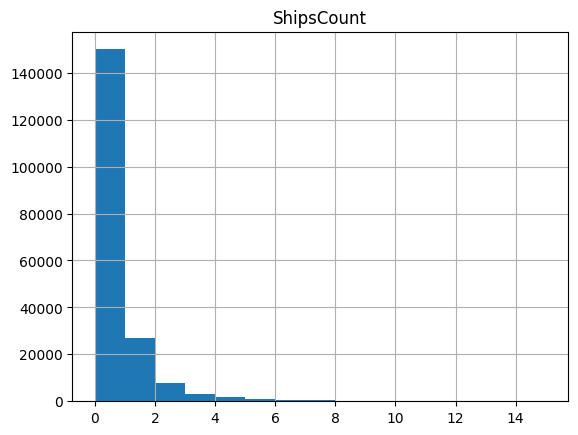

In [9]:
ships_nums.hist(bins = 15)

In [10]:
ships_nums.value_counts()

ShipsCount
0             150000
1              27104
2               7674
3               2954
4               1622
5                925
6                657
7                406
8                318
9                243
10               168
11               144
12               124
14                76
13                75
15                66
Name: count, dtype: int64

Total amount of labeled ships

In [11]:
ships_nums.sum()

ShipsCount    81723
dtype: int64

In [12]:
ships_nums.describe()

,ShipsCount
count,192556.000000
mean,0.424412
std,1.199094
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,15.000000


Persantage of background images

In [31]:
ships_nums.value_counts()[0] / ships_nums.value_counts().sum()

0.7789941627370739

There are 81723 labeled ships over 192556 images. 78% of images have no labeled ships on them.

### Size and shape of images

Check if all the images are of the same size:

In [32]:
def get_im_size(image):
    path = f'./data/airbus-ship-detection/train_v2/{image}'
    cv2.imread(path)
    w, h, d = cv2.imread(path).shape
    return w, h

In [33]:
image_sizes = pd.DataFrame(columns = ['ImageId', 'Width', 'Height'])

for im in metadata['ImageId'].unique():
    w, h = get_im_size(im)
    image_sizes.loc[len(image_sizes)] = {'ImageId': im,'Width': w, 'Height':h }

In [34]:
print(image_sizes['Height'].unique().shape)
print(image_sizes['Width'].unique().shape)

(1,)
(1,)


In [35]:
print(image_sizes['Height'].unique())
print(image_sizes['Width'].unique())

[768]
[768]


All the images are of the same size 768x768

          ImageId                                      EncodedPixels
60  00113a75c.jpg  401790 1 402557 3 403325 5 404092 7 404859 9 4...
61  00113a75c.jpg  110888 2 111654 4 112420 7 113186 9 113953 11 ...
62  00113a75c.jpg  394109 1 394876 4 395644 5 396411 8 397178 10 ...
63  00113a75c.jpg  123159 1 123925 4 124691 6 125458 8 126227 7 1...
64  00113a75c.jpg  172862 2 173628 4 174394 7 175160 9 175926 12 ...
65  00113a75c.jpg  536114 1 536880 4 537646 6 538413 8 539179 10 ...
66  00113a75c.jpg  111647 1 112413 3 113179 6 113945 8 114711 10 ...


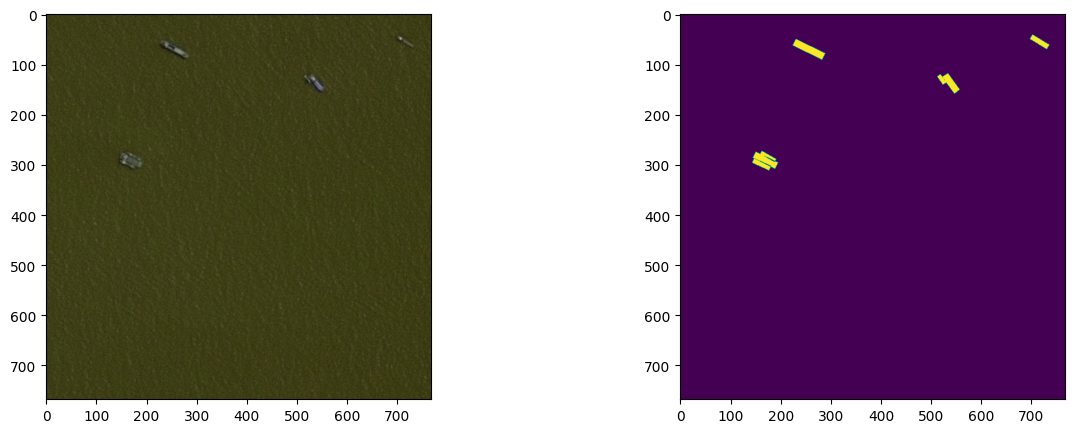

In [36]:
import utils as ut

def show_ships(im_name, size = 768):

    rle_rows = metadata[metadata['ImageId'] == im_name]
    if len(rle_rows) == 0:
        return
    
    print(rle_rows)

    ship_count = len(rle_rows)
    all_ships = np.zeros((size,size))
    for rle_code in rle_rows['EncodedPixels']:
        all_ships += ut.rle_decode(rle_code, (size,size))
    return all_ships.T

path = './/data//airbus-ship-detection//train_v2//00113a75c.jpg'
im = cv2.imread(path)
f,ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(im)
ax[1].imshow(show_ships('00113a75c.jpg'))
plt.show()

The dataset of square images 768x768 pixels. Most of the images 78% do not contain ships the rest contain from 1 to 15 ships. Labels are provided in .csv file, where each row contains image filename and ship position in run-length encoding format. Overall, there are 81723 ships on 192556 images. All images have same size. 

## Learning report

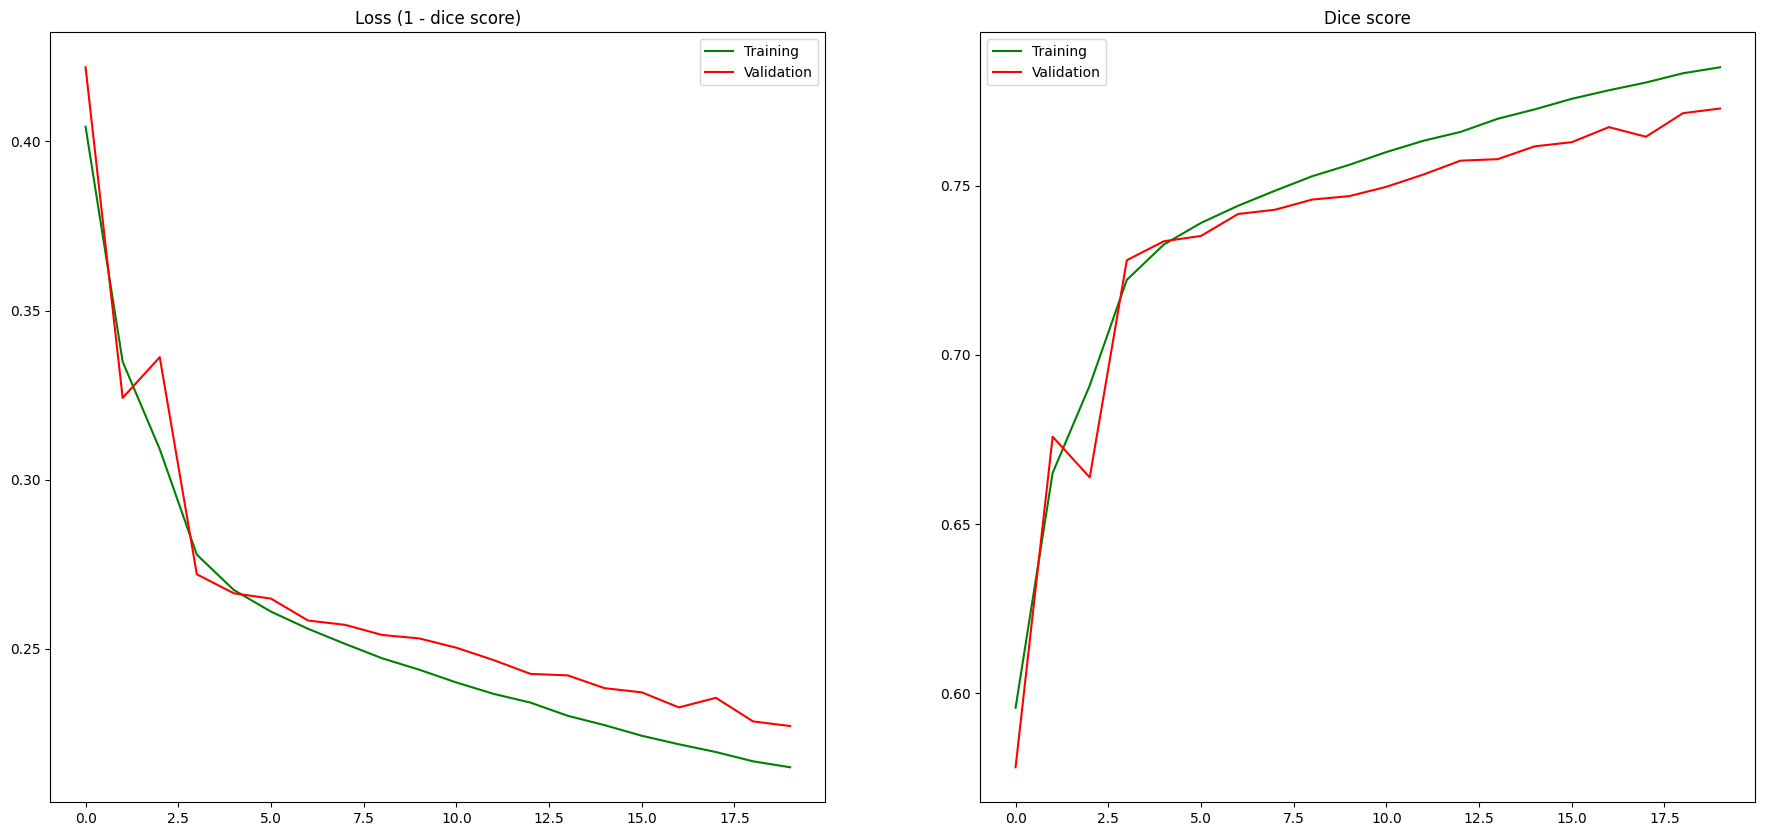

In [37]:
loss_history = pd.read_csv('.//log//log.csv')
def show_loss(loss_history):
    epochs = np.array(loss_history['epoch'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, loss_history['loss'], 'g-',
                 epochs, loss_history['val_loss'], 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss (1 - dice score)')
    
    _ = ax2.plot(epochs, loss_history['dice_score'], 'g-',
                 epochs, loss_history['val_dice_score'], 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Dice score')

show_loss(loss_history)